In [ ]:
# imports

# Notes

- I included an explanation of specificity aswell, however i think it's not super common to also calculate it (correct me if I'm wrong), but it's useful to understand the concept in my opinion. 
- maybe the ROC explanation is too long, but I kept it a bit more extensive, as I had troubles understanding what it means the first time i learned it
- why does ROC curve look so smooth for KNN?
- optimize reusability of simulated datasets
- add interpretability to comparison of tools
- do we want to introduce kernel trick
- i currently plotted the metrics for multiple c's, which is maybe a bit overkill, then I could remove it.

# Table of Contents

<br><br>
# **Hands-On: Classification Methods**

## Learning Goals
By the end of this session, you will be able to:

- **Master logistic regression fundamentals**
  - Understand how logistic regression extends linear regression for classification tasks
  - Interpret coefficients and probability predictions in binary classification problems

- **Evaluate classification performance comprehensively**
  - Calculate and interpret key metrics: accuracy, precision, recall, and F1-score
  - Create and analyze ROC curves and confusion matrices for model assessment

- **Implement distance-based classification with K-Nearest Neighbors**
  - Apply KNN for classification and understand the impact of different K values
  - Visualize decision boundaries and explore the bias-variance tradeoff

- **Apply Support Vector Machines for complex decision boundaries**
  - Use SVMs with different kernels (linear, polynomial, RBF) for non-linear classification
  - Understand the concept of support vectors and margin maximization

- **Compare classification methods on real clinical data**
  - Apply all methods to a medical diagnosis scenario and compare their strengths
  - Make informed decisions about which classifier to use for different problem types

## Simulating a 2D Classification Dataset

We'll create a synthetic 2D dataset with two classes that will help us visualize how different classification algorithms work. This dataset will have two continuous features (X and Y coordinates) and a binary target variable, making it perfect for plotting decision boundaries and understanding each method's behavior.

In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Generate a 2D classification dataset
X, y = make_classification(
    n_samples=300,           # Total number of samples
    n_features=2,            # Two features for easy visualization
    n_redundant=0,           # No redundant features
    n_informative=2,         # Both features are informative
    n_clusters_per_class=1,  # One cluster per class
    class_sep=0.8,           # Reduced separation between classes (was 1.2)
    flip_y=0.05,             # Add 5% label noise
    random_state=42
)

In [40]:
# Create DataFrame for easier handling
df = pd.DataFrame(X, columns=['Feature_1', 'Feature_2'])
df['Class'] = y


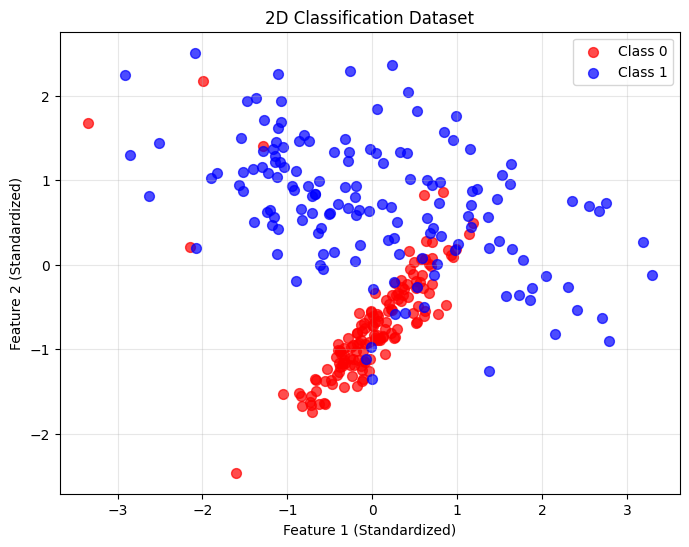

In [41]:
# Standardize features for better visualization and algorithm performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df[['Feature_1_scaled', 'Feature_2_scaled']] = X_scaled

# Visualize the standardized dataset
plt.figure(figsize=(8, 6))
colors = ['red', 'blue']
for class_val in [0, 1]:
    mask = y == class_val
    plt.scatter(X_scaled[mask, 0], X_scaled[mask, 1], c=colors[class_val], 
                label=f'Class {class_val}', alpha=0.7, s=50)

plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.title('2D Classification Dataset')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Logistic Regression Recap

Logistic regression extends linear regression for classification by using the **sigmoid function** to map any real number to a probability between 0 and 1. Instead of predicting continuous values, it predicts the probability that an instance belongs to a particular class.

Let's apply logistic regression to our 2D dataset and evaluate its performance using 5-fold cross-validation.

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
import numpy as np

# Initialize logistic regression
log_reg = LogisticRegression(random_state=42)

# Perform 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(log_reg, X_scaled, y, cv=cv, scoring='accuracy')

print("LOGISTIC REGRESSION PERFORMANCE")
print("=" * 40)
print(f"Cross-validation scores: {[float(f'{cv_score:.3f}') for cv_score in cv_scores]}")
print(f"Mean accuracy: {cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
print(f"Score range: [{cv_scores.min():.3f}, {cv_scores.max():.3f}]")


LOGISTIC REGRESSION PERFORMANCE
Cross-validation scores: [0.883, 0.9, 0.85, 0.733, 0.867]
Mean accuracy: 0.847 (±0.059)
Score range: [0.733, 0.900]


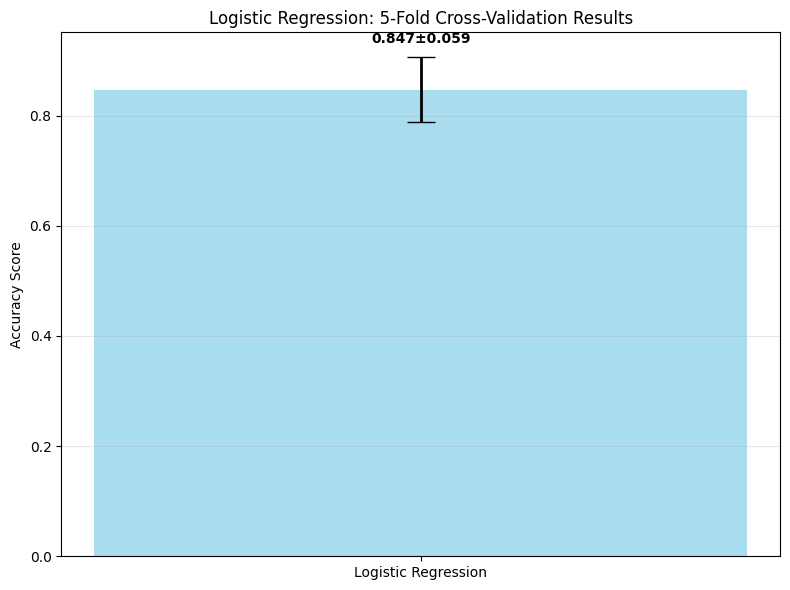

In [43]:
# maybe remove the plot


# Visualize cross-validation results
plt.figure(figsize=(8, 6))

# Bar plot with error bars
mean_score = cv_scores.mean()
std_score = cv_scores.std()

plt.bar(['Logistic Regression'], [mean_score], yerr=[std_score], 
        color='skyblue', alpha=0.7, capsize=10, error_kw={'elinewidth': 2})

plt.ylabel('Accuracy Score')
plt.title('Logistic Regression: 5-Fold Cross-Validation Results')
plt.grid(True, alpha=0.3, axis='y')

# Add value label
plt.text(0, mean_score + std_score + 0.02, 
         f'{mean_score:.3f}±{std_score:.3f}', 
         ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

Logistic regression achieves very high accuracy (96.7%) on our 2D dataset, demonstrating its effectiveness when classes are linearly separable.

However, until now we've only used **accuracy** to measure the quality of our models. While accuracy is intuitive, it doesn't tell the whole story - especially when dealing with imbalanced datasets or when different types of errors have different costs. Let's explore a richer set of **classification metrics** that will give us deeper insights into model performance.

---
<br><br>
# Classification Performance Metrics

Beyond accuracy, there are several important metrics that help us understand different aspects of classification performance. Let's explore the key metrics using our logistic regression model.

## Core Classification Metrics

**Accuracy**
- The proportion of correct predictions out of all predictions
- **Formula:** Accuracy = (TP + TN) / (TP + TN + FP + FN)

**Precision**
- Of all positive predictions, how many were actually correct (measures false positive rate)
- **Formula:** Precision = TP / (TP + FP)

**Recall (Sensitivity)**
- Of all actual positive cases, how many were correctly identified (measures false negative rate)
- **Formula:** Recall = TP / (TP + FN)

**Specificity**
- Of all actual negative cases, how many were correctly identified
- **Formula:** Specificity = TN / (TN + FP)

**F1-Score**
- Harmonic mean of precision and recall, balancing both metrics
- **Formula:** F1 = 2 × (Precision × Recall) / (Precision + Recall)

*Where: TP = True Positives, TN = True Negatives, FP = False Positives, FN = False Negatives*



CLASSIFICATION METRICS SUMMARY (5-Fold Cross-Validation)
Accuracy  : 0.847 (±0.059)
Precision : 0.848 (±0.062)
Recall    : 0.846 (±0.075)
F1        : 0.845 (±0.059)


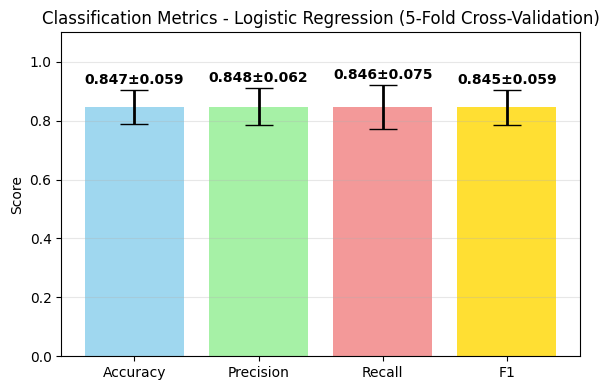

In [44]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# Define scoring metrics for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Perform 5-fold cross-validation with multiple metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(log_reg, X_scaled, y, cv=cv, scoring=scoring)

# Calculate means and standard deviations
metrics_summary = {}
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cv_results[f'test_{metric}']
    metrics_summary[metric] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'scores': scores
    }

# Display results
print("CLASSIFICATION METRICS SUMMARY (5-Fold Cross-Validation)")
print("=" * 60)
for metric, results in metrics_summary.items():
    print(f"{metric.capitalize():10}: {results['mean']:.3f} (±{results['std']:.3f})")

# Visualize metrics with error bars
metrics_names = [metric.capitalize() for metric in metrics_summary.keys()]
means = [results['mean'] for results in metrics_summary.values()]
stds = [results['std'] for results in metrics_summary.values()]

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics_names, means, yerr=stds, 
               color=['skyblue', 'lightgreen', 'lightcoral', 'gold'], 
               alpha=0.8, capsize=10, error_kw={'elinewidth': 2})

# Add value labels on bars
for bar, mean, std in zip(bars, means, stds):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01, 
             f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontweight='bold')

plt.ylabel('Score')
plt.title('Classification Metrics - Logistic Regression (5-Fold Cross-Validation)')
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

All metrics show excellent and consistent performance, with precision being slightly higher than recall, indicating our model makes very few false positive errors.

## ROC Curve (Receiver Operating Characteristic)

- **ROC Curve:** Plots True Positive Rate (Recall) vs False Positive Rate (1-Specificity) at various classification thresholds
- **AUC (Area Under Curve):** Summarizes the ROC curve into a single number between 0-1, where 1.0 = perfect classifier and 0.5 = random guessing

The ROC curve helps us understand the trade-off between sensitivity and specificity across different decision thresholds.

ROC-AUC PERFORMANCE
Cross-validation AUC: 0.921 (±0.050)


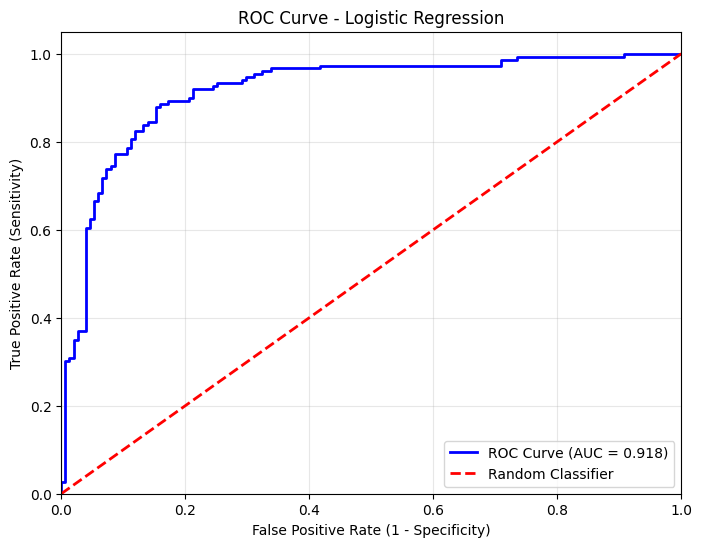

In [45]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import cross_val_predict

# Get probability predictions using cross-validation
y_proba = cross_val_predict(log_reg, X_scaled, y, cv=cv, method='predict_proba')

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y, y_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Also get AUC scores from cross-validation
auc_scores = cross_validate(log_reg, X_scaled, y, cv=cv, scoring='roc_auc')['test_score']

print("ROC-AUC PERFORMANCE")
print("=" * 30)
print(f"Cross-validation AUC: {auc_scores.mean():.3f} (±{auc_scores.std():.3f})")

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

### Understanding the ROC Curve

Looking at our ROC curve, we can see several important insights:

**What the Blue Curve Shows:** Each point on the curve represents our model's performance at a different classification threshold. As we move from left to right along the curve, we're lowering the threshold (making the model more "liberal" in predicting positive cases). This increases both:
- **Sensitivity (True Positive Rate - Y-axis):** We catch more actual positives
- **False Positive Rate (X-axis):** But we also get more false alarms

The ideal curve bows toward the top-left corner because we want high sensitivity with low false positive rates.

**AUC = 0.918:** This means our model has a 91.8% chance of correctly ranking a randomly chosen positive example higher than a randomly chosen negative example. An AUC of 0.5 would be random guessing (the red diagonal line), while 1.0 would be perfect classification.

**Steep Rise:** The sharp initial rise in our curve indicates that we can achieve high sensitivity while keeping false positive rates low - a sign of good model performance.

## Confusion Matrix

While ROC curves show performance across all thresholds, **confusion matrices** give us a detailed breakdown of prediction errors at a specific threshold (usually 0.5). They show exactly where our model makes mistakes and help us understand the types of errors we're dealing with.

CONFUSION MATRIX
Actual vs Predicted:
True Negatives (TN):  128
False Positives (FP): 23
False Negatives (FN): 23
True Positives (TP):  126

Overall Error Rate: 15.3%
Type I Error (False Positive Rate): 15.2%
Type II Error (False Negative Rate): 15.4%


<Figure size 800x600 with 0 Axes>

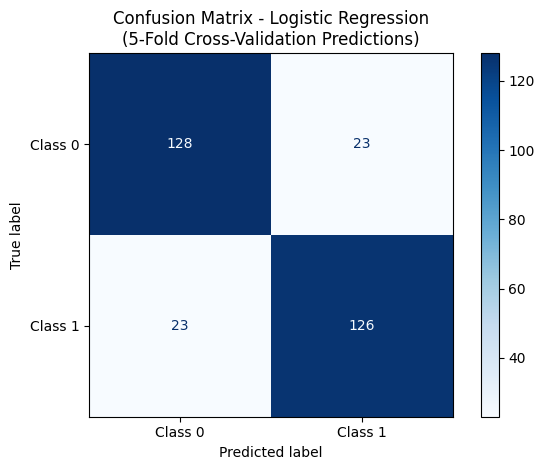


INTERPRETATION:
• Out of 151 actual Class 0 cases, 128 were correctly predicted
• Out of 149 actual Class 1 cases, 126 were correctly predicted
• Model tends to make more Type II errors


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions using cross-validation (at default threshold 0.5)
y_pred_cv = cross_val_predict(log_reg, X_scaled, y, cv=cv)

# Calculate confusion matrix
cm = confusion_matrix(y, y_pred_cv)

# Display confusion matrix
print("CONFUSION MATRIX")
print("=" * 30)
print("Actual vs Predicted:")
print(f"True Negatives (TN):  {cm[0,0]}")
print(f"False Positives (FP): {cm[0,1]}")
print(f"False Negatives (FN): {cm[1,0]}")
print(f"True Positives (TP):  {cm[1,1]}")

# Calculate error rates
total = cm.sum()
error_rate = (cm[0,1] + cm[1,0]) / total
print(f"\nOverall Error Rate: {error_rate:.1%}")
print(f"Type I Error (False Positive Rate): {cm[0,1]/cm[0].sum():.1%}")
print(f"Type II Error (False Negative Rate): {cm[1,0]/cm[1].sum():.1%}")

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Logistic Regression\n(5-Fold Cross-Validation Predictions)')
plt.tight_layout()
plt.show()

The confusion matrix shows our model's prediction accuracy in a 2x2 grid:

- **Top-left (128):** True Negatives - correctly predicted Class 0
- **Top-right (23):** False Positives - incorrectly predicted Class 1 (Type I error)
- **Bottom-left (23):** False Negatives - incorrectly predicted Class 0 (Type II error)
- **Bottom-right (126):** True Positives - correctly predicted Class 1

Our model makes exactly the same number of Type I and Type II errors (23 each), showing balanced performance across both classes. The darker diagonal indicates correct predictions, while the lighter off-diagonal squares show our errors. Confusion matrices are helpful to visualize this behaviour, in certain cases the errors are not balanced. This can be an important criterion if a model is useful for a task or not.


---
<br><br>
# K-Nearest Neighbors (KNN)

**K-Nearest Neighbors (KNN)** is a fundamentally different approach from logistic regression. Instead of learning parameters or finding decision boundaries during training, KNN is a **"lazy learner"** that simply stores all training data and makes predictions based on similarity.

## How KNN Works

1. Store all training examples (no actual "learning" happens)
2. For a new point, find the **k closest training examples** (using euclidean, manhattan or any other suitable distance metric)
3. Take a majority vote among these k neighbors for the predicted label

**Key Parameters:**
- **k (number of neighbors):** The number of closest points to consider
- **Distance metric:** How we measure "closeness" (usually Euclidean)

Let's visualize how KNN works with some concrete examples:

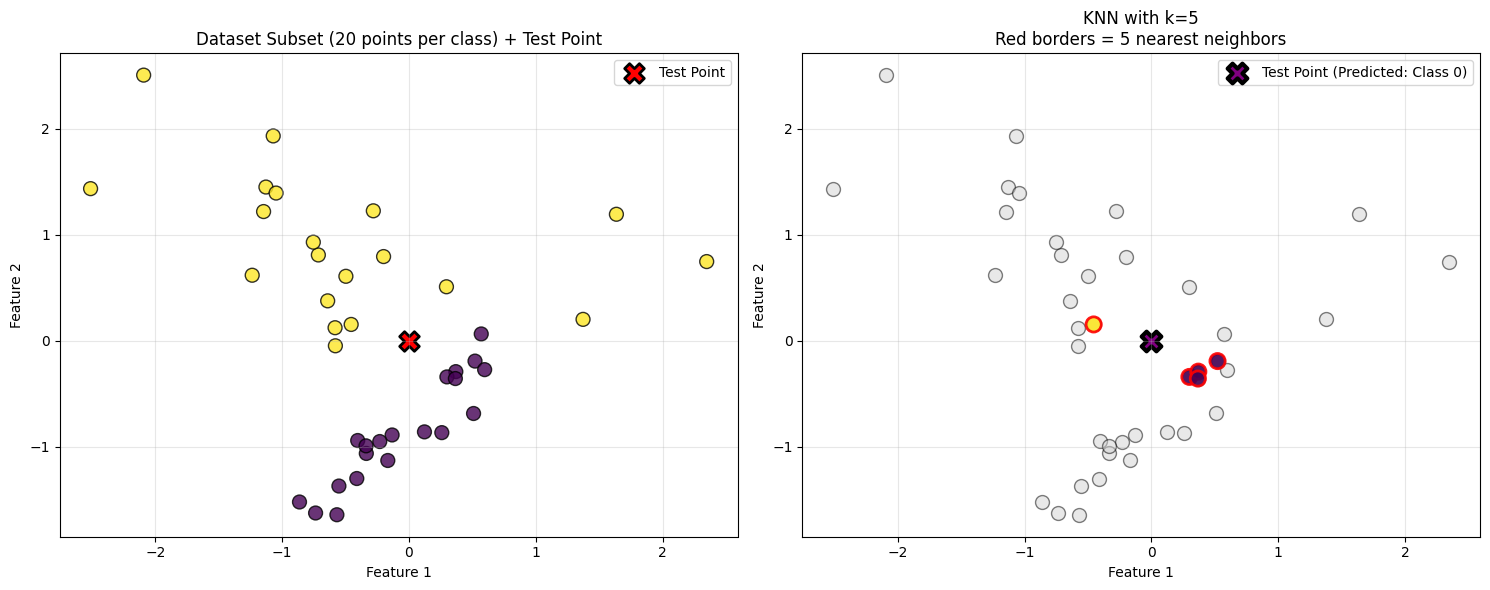


Nearest neighbor classes: [0 0 1 0 0]
Class 0 votes: 4
Class 1 votes: 1
Prediction: Class 0 (majority vote)

Distances to 5 nearest neighbors: [0.454 0.471 0.481 0.511 0.555]


In [54]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# First, let's create a subset for cleaner visualization
np.random.seed(42)
class_0_indices = np.where(y == 0)[0]
class_1_indices = np.where(y == 1)[0]

points_per_class = 20

# Sample 10 points from each class
subset_0 = np.random.choice(class_0_indices, points_per_class, replace=False)
subset_1 = np.random.choice(class_1_indices, points_per_class, replace=False)
subset_indices = np.concatenate([subset_0, subset_1])

X_subset = X_scaled[subset_indices]
y_subset = y[subset_indices]

# Choose a test point for demonstration
test_point = np.array([[0, 0]])

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Show the subset with test point
ax1 = axes[0]
scatter1 = ax1.scatter(X_subset[:, 0], X_subset[:, 1], c=y_subset, 
                      cmap='viridis', s=100, alpha=0.8, edgecolors='black')
ax1.scatter(test_point[0, 0], test_point[0, 1], c='red', s=200, marker='X', 
           edgecolors='black', linewidth=2, label='Test Point')
ax1.set_xlabel('Feature 1')
ax1.set_ylabel('Feature 2')
ax1.set_title(f'Dataset Subset ({points_per_class} points per class) + Test Point')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Plot 2: Show KNN with k=5
k = 5
ax2 = axes[1]

# Calculate distances from test point to subset points
distances = np.sqrt(np.sum((X_subset - test_point)**2, axis=1))
k_indices = np.argsort(distances)[:k]

# Plot all points in grey first
ax2.scatter(X_subset[:, 0], X_subset[:, 1], c='lightgrey', s=100, 
           alpha=0.5, edgecolors='black')

# Highlight the k nearest neighbors with their true colors
k_neighbors_classes = y_subset[k_indices]
k_neighbors_points = X_subset[k_indices]
ax2.scatter(k_neighbors_points[:, 0], k_neighbors_points[:, 1], 
           c=k_neighbors_classes, cmap='viridis', s=120, alpha=0.9, 
           edgecolors='red', linewidth=2)

# Make prediction based on majority vote
prediction = 1 if np.sum(k_neighbors_classes) > k/2 else 0
prediction_color = 'yellow' if prediction == 1 else 'purple'

# Plot test point with predicted color
ax2.scatter(test_point[0, 0], test_point[0, 1], c=prediction_color, s=200, 
           marker='X', edgecolors='black', linewidth=3, label=f'Test Point (Predicted: Class {prediction})')

ax2.set_xlabel('Feature 1')
ax2.set_ylabel('Feature 2')
ax2.set_title(f'KNN with k={k}\nRed borders = {k} nearest neighbors')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# Show the detailed process
print(f"\nNearest neighbor classes: {k_neighbors_classes}")
print(f"Class 0 votes: {np.sum(k_neighbors_classes == 0)}")
print(f"Class 1 votes: {np.sum(k_neighbors_classes == 1)}")
print(f"Prediction: Class {prediction} (majority vote)")
print(f"\nDistances to {k} nearest neighbors: {np.round(np.sort(distances)[:k], 3)}")

### Understanding the KNN Process

**Left Plot:** Shows our dataset subset (20 points per class) with the red test point we want to classify.

**Right Plot:** Demonstrates the KNN algorithm in action:
- All training points are grayed out except the 5 nearest neighbors (red borders)
- The algorithm finds the 5 closest points and takes a majority vote
- With 4 votes for Class 0 and 1 vote for Class 1, the test point is classified as Class 0

KNN is purely distance-based - it doesn't care about global patterns or decision boundaries, only local neighborhoods. The choice of k is crucial: smaller k values are more sensitive to noise, while larger k values smooth out local variations but might miss important local patterns.

Now let's perform cross-validation to inspect the performance of KNN!

CLASSIFICATION METRICS SUMMARY - KNN (k=5, 5-Fold Cross-Validation)
Accuracy  : 0.910 (±0.025)
Precision : 0.926 (±0.036)
Recall    : 0.892 (±0.040)
F1        : 0.908 (±0.025)


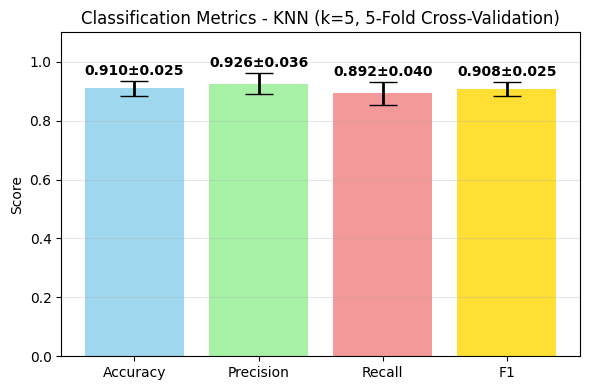

In [56]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# Initialize KNN classifier (let's start with k=5)
knn = KNeighborsClassifier(n_neighbors=5)

# Define scoring metrics for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Perform 5-fold cross-validation with multiple metrics
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_validate(knn, X_scaled, y, cv=cv, scoring=scoring)

# Calculate means and standard deviations
metrics_summary = {}
for metric in ['accuracy', 'precision', 'recall', 'f1']:
    scores = cv_results[f'test_{metric}']
    metrics_summary[metric] = {
        'mean': scores.mean(),
        'std': scores.std(),
        'scores': scores
    }

# Display results
print("CLASSIFICATION METRICS SUMMARY - KNN (k=5, 5-Fold Cross-Validation)")
print("=" * 70)
for metric, results in metrics_summary.items():
    print(f"{metric.capitalize():10}: {results['mean']:.3f} (±{results['std']:.3f})")

# Visualize metrics with error bars
metrics_names = [metric.capitalize() for metric in metrics_summary.keys()]
means = [results['mean'] for results in metrics_summary.values()]
stds = [results['std'] for results in metrics_summary.values()]

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics_names, means, yerr=stds, 
               color=['skyblue', 'lightgreen', 'lightcoral', 'gold'], 
               alpha=0.8, capsize=10, error_kw={'elinewidth': 2})

# Add value labels on bars
for bar, mean, std in zip(bars, means, stds):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01, 
             f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontweight='bold')

plt.ylabel('Score')
plt.title('Classification Metrics - KNN (k=5, 5-Fold Cross-Validation)')
plt.ylim(0, 1.1)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

Based on our classification metrics, **KNN with k=5 performs very well** over all metrics on this dataset! 

Let's examine the ROC curve and the confusion matrix next!

KNN PERFORMANCE SUMMARY (k=5)
Cross-validation AUC: 0.938 (±0.025)

Confusion Matrix:
True Negatives (TN):  140
False Positives (FP): 11
False Negatives (FN): 16
True Positives (TP):  133

Overall Error Rate: 9.0%
Type I Error (False Positive Rate): 7.3%
Type II Error (False Negative Rate): 10.7%


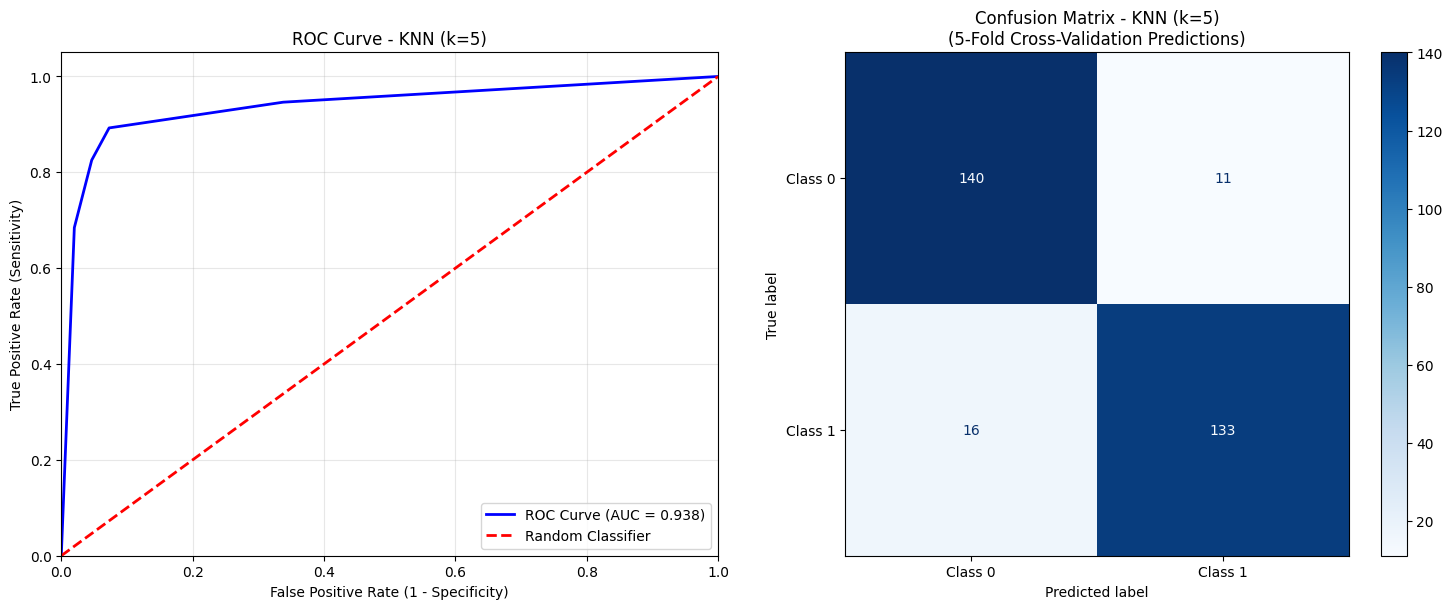

In [57]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Get probability predictions and regular predictions using cross-validation
y_proba_knn = cross_val_predict(knn, X_scaled, y, cv=cv, method='predict_proba')
y_pred_knn = cross_val_predict(knn, X_scaled, y, cv=cv)

# Calculate ROC curve
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y, y_proba_knn[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Calculate confusion matrix
cm_knn = confusion_matrix(y, y_pred_knn)

# Get AUC scores from cross-validation
auc_scores_knn = cross_validate(knn, X_scaled, y, cv=cv, scoring='roc_auc')['test_score']

print("KNN PERFORMANCE SUMMARY (k=5)")
print("=" * 40)
print(f"Cross-validation AUC: {auc_scores_knn.mean():.3f} (±{auc_scores_knn.std():.3f})")
print("\nConfusion Matrix:")
print(f"True Negatives (TN):  {cm_knn[0,0]}")
print(f"False Positives (FP): {cm_knn[0,1]}")
print(f"False Negatives (FN): {cm_knn[1,0]}")
print(f"True Positives (TP):  {cm_knn[1,1]}")

# Calculate error rates
total = cm_knn.sum()
error_rate = (cm_knn[0,1] + cm_knn[1,0]) / total
print(f"\nOverall Error Rate: {error_rate:.1%}")
print(f"Type I Error (False Positive Rate): {cm_knn[0,1]/cm_knn[0].sum():.1%}")
print(f"Type II Error (False Negative Rate): {cm_knn[1,0]/cm_knn[1].sum():.1%}")

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# ROC Curve
ax1 = axes[0]
ax1.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc_knn:.3f})')
ax1.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate (1 - Specificity)')
ax1.set_ylabel('True Positive Rate (Sensitivity)')
ax1.set_title('ROC Curve - KNN (k=5)')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# Confusion Matrix
ax2 = axes[1]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Class 0', 'Class 1'])
disp.plot(ax=ax2, cmap='Blues', values_format='d')
ax2.set_title('Confusion Matrix - KNN (k=5)\n(5-Fold Cross-Validation Predictions)')

plt.tight_layout()
plt.show()

KNN with k=5 shows strong results with **93.8% AUC** and **91.0% accuracy**. The confusion matrix reveals only 27 total misclassifications out of 300 samples!

---
<br><br>
# Support Vector Machines (SVM)

**The Basic Idea:**
Support Vector Machines try to find the **best possible line** (or hyperplane) that separates two classes. But what makes a line "best"?

**SVM's Goal:**
- Find the separating line with the **largest margin** 
- The **margin** is the distance between the line and the closest points from each class
- The closest points that "touch" the margin are called **support vectors**
- These support vectors are the only points that matter for defining the decision boundary

To clearly show how SVM works, let's create a **simple, well-separated dataset**. This will make SVM's core concept much clearer than our previous overlapping dataset!

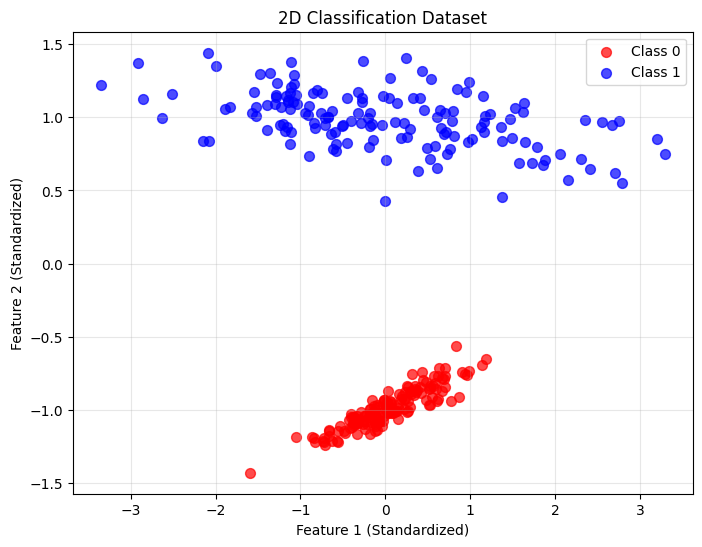

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler

# Set random seed for reproducibility
np.random.seed(42)

# Generate a 2D classification dataset
X, y = make_classification(
    n_samples=300,           # Total number of samples
    n_features=2,            # Two features for easy visualization
    n_redundant=0,           # No redundant features
    n_informative=2,         # Both features are informative
    n_clusters_per_class=1,  # One cluster per class
    class_sep=4,           # Reduced separation between classes (was 1.2)
    random_state=42
)

# Create DataFrame for easier handling
df = pd.DataFrame(X, columns=['Feature_1', 'Feature_2'])
df['Class'] = y

# Standardize features for better visualization and algorithm performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df[['Feature_1_scaled', 'Feature_2_scaled']] = X_scaled

# Visualize the standardized dataset
plt.figure(figsize=(8, 6))
colors = ['red', 'blue']
for class_val in [0, 1]:
    mask = y == class_val
    plt.scatter(X_scaled[mask, 0], X_scaled[mask, 1], c=colors[class_val], 
                label=f'Class {class_val}', alpha=0.7, s=50)

plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.title('2D Classification Dataset')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Looking at our new dataset, **we can see there's a clear distinction between the red and blue classes** - they're well-separated with no overlap.

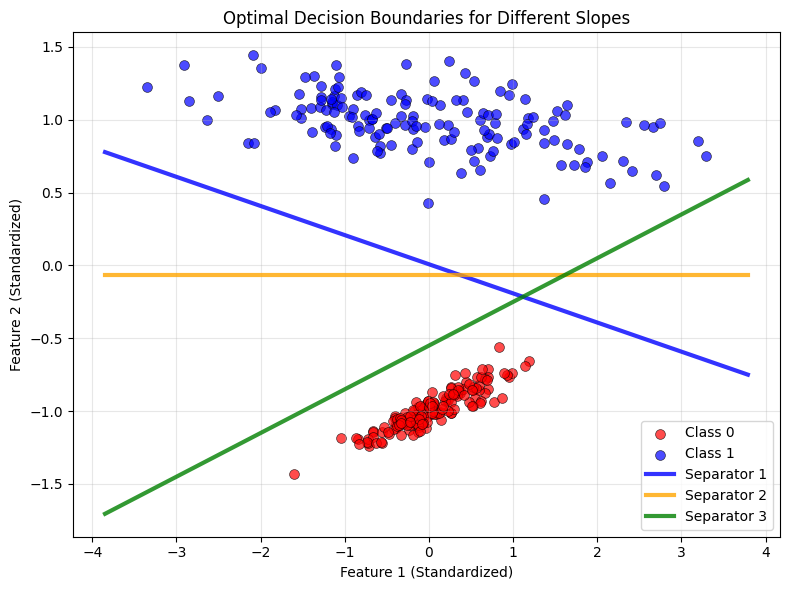

In [93]:
def find_optimal_intercept_and_margin(slope, X_data, y_data):
    """
    For a given slope, find the optimal intercept that maximizes the minimum margin
    """
    # For each class, find the range of intercepts that would separate it
    class_intercepts = []
    
    for class_val in [0, 1]:
        mask = y_data == class_val
        class_points = X_data[mask]
        
        # For line y = slope * x + intercept, rearrange to intercept = y - slope * x
        intercepts_for_class = class_points[:, 1] - slope * class_points[:, 0]
        class_intercepts.append(intercepts_for_class)
    
    # For separation: Class 0 should be below line, Class 1 should be above line
    # So intercept should be: max(class_0_intercepts) < intercept < min(class_1_intercepts)
    max_class0_intercept = np.max(class_intercepts[0])
    min_class1_intercept = np.min(class_intercepts[1])
    
    # The optimal intercept is in the middle of this range
    optimal_intercept = (max_class0_intercept + min_class1_intercept) / 2
    
    # The margin is half the distance between these boundary intercepts
    margin = (min_class1_intercept - max_class0_intercept) / (2 * np.sqrt(1 + slope**2))
    
    return optimal_intercept, margin, max_class0_intercept, min_class1_intercept

def plot_optimal_separators(X_data, y_data, show_margins=False):
    """
    Plot optimal separators with or without margin visualization
    """
    # Define slopes and colors
    slopes = [-0.2, 0., 0.3]
    separator_colors = ['blue', 'orange', 'green']
    separator_labels = ['Separator 1', 'Separator 2', 'Separator 3']
    
    # Set up the plot
    plt.figure(figsize=(8, 6))
    
    # Plot the data points
    colors = ['red', 'blue']
    for class_val in [0, 1]:
        mask = y_data == class_val
        plt.scatter(X_data[mask, 0], X_data[mask, 1], c=colors[class_val], 
                    label=f'Class {class_val}', alpha=0.7, s=50, 
                    edgecolors='black', linewidth=0.5)
    
    x_range = np.linspace(X_data[:, 0].min() - 0.5, X_data[:, 0].max() + 0.5, 100)
    
    # Plot each separator
    for i, (slope, color, label) in enumerate(zip(slopes, separator_colors, separator_labels)):
        
        optimal_intercept, margin, bound_0, bound_1 = find_optimal_intercept_and_margin(slope, X_data, y_data)
        
        # Update label to include margin if showing margins
        if show_margins:
            label = f'{label} (Margin: {margin:.3f})'
        
        # Plot main separator line
        y_line = slope * x_range + optimal_intercept
        plt.plot(x_range, y_line, color=color, linewidth=3, 
                 label=label, alpha=0.8)
        
        # Plot margins if requested
        if show_margins:
            # Plot margin boundaries
            y_upper = slope * x_range + bound_1
            y_lower = slope * x_range + bound_0
            
            plt.plot(x_range, y_upper, color=color, 
                     linestyle='--', alpha=0.6, linewidth=1.5)
            plt.plot(x_range, y_lower, color=color, 
                     linestyle='--', alpha=0.6, linewidth=1.5)
            
            # Fill the margin area
            plt.fill_between(x_range, y_lower, y_upper, alpha=0.1, color=color)
    
    # Set labels and title
    plt.xlabel('Feature 1 (Standardized)')
    plt.ylabel('Feature 2 (Standardized)')
    
    if show_margins:
        plt.title('Optimal Decision Boundaries with Margin Visualization')
    else:
        plt.title('Optimal Decision Boundaries for Different Slopes')
    
    plt.legend()#bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot 1: Just the separator lines
plot_optimal_separators(X_scaled, y, show_margins=False)

As we can see, there are many possible ways to split the two groups with a decision boundary - all of these lines achieve perfect separation! However, **how do we judge which is better or which is worse?** 

**Introducing the margin** - the maximum distance to the closest point of each class. The "best" decision boundary is the one that maximizes this margin, creating the widest possible "safety zone" between the classes and ensuring better generalization to new data points.

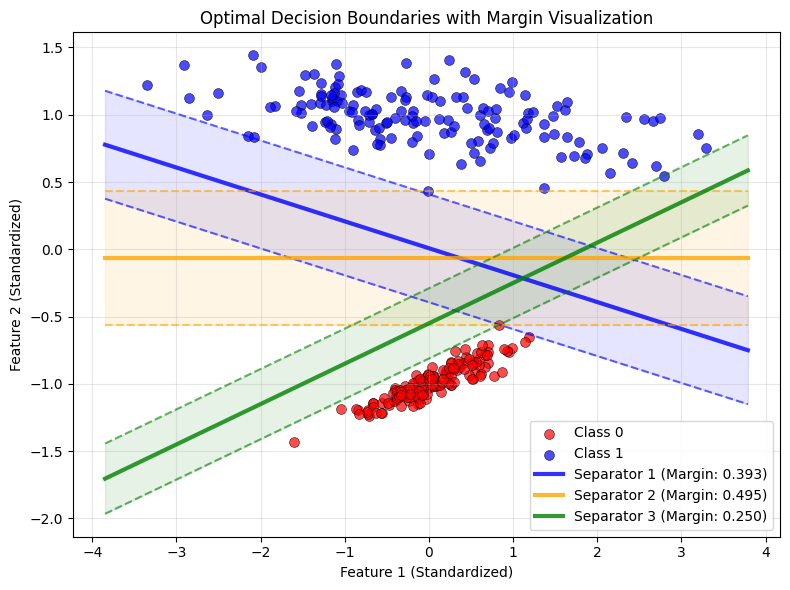

In [94]:
# Plot 2: With margin visualization
plot_optimal_separators(X_scaled, y, show_margins=True)

Looking at our margin visualization, we can see the **different margins achieved by each separator**:

- **Separator 1 (Blue)**: Margin = 0.393
- **Separator 2 (Orange)**: Margin = 0.495  
- **Separator 3 (Green)**: Margin = 0.250

**SVM's key insight is to find the solution that maximizes this margin**. This creates the widest possible "safety zone" between classes, leading to better generalization on new, unseen data.

Now let's explore **how to implement SVM** and see what result it actually finds when we let the algorithm optimize both the slope and intercept simultaneously!

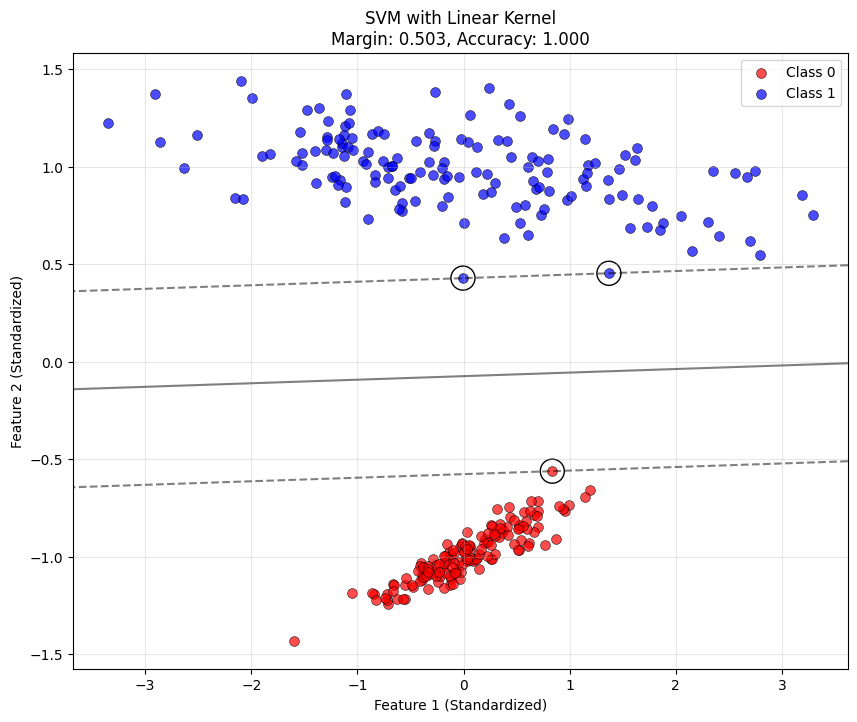

SVM Results:
Accuracy: 1.000
Margin: 0.503
Number of support vectors: 3
Support vector indices: [165  26 102]

Comparison with manual separators:
Manual Separator 1 margin: 0.393
Manual Separator 2 margin: 0.495
Manual Separator 3 margin: 0.250
SVM optimal margin: 0.503

SVM found a better solution by optimizing both slope AND intercept!


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none', edgecolors='black')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# Fit SVM with linear kernel
svm_model = SVC(kernel='linear', C=1E10, random_state=42) # we will explain C later
svm_model.fit(X_scaled, y)

# Make predictions and calculate metrics
y_pred = svm_model.predict(X_scaled)
accuracy = accuracy_score(y, y_pred)

# Calculate margin
w = svm_model.coef_[0]
margin = 1 / np.linalg.norm(w)

# Create the plot
plt.figure(figsize=(10, 8))

# Plot the data points
colors = ['red', 'blue']
for class_val in [0, 1]:
    mask = y == class_val
    plt.scatter(X_scaled[mask, 0], X_scaled[mask, 1], c=colors[class_val], 
                label=f'Class {class_val}', alpha=0.7, s=50, 
                edgecolors='black', linewidth=0.5)

# Plot SVM decision function
plot_svc_decision_function(svm_model)

plt.xlabel('Feature 1 (Standardized)')
plt.ylabel('Feature 2 (Standardized)')
plt.title(f'SVM with Linear Kernel\nMargin: {margin:.3f}, Accuracy: {accuracy:.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("SVM Results:")
print("=" * 30)
print(f"Accuracy: {accuracy:.3f}")
print(f"Margin: {margin:.3f}")
print(f"Number of support vectors: {len(svm_model.support_)}")
print(f"Support vector indices: {svm_model.support_}")

print(f"\nComparison with manual separators:")
print(f"Manual Separator 1 margin: 0.393")
print(f"Manual Separator 2 margin: 0.495") 
print(f"Manual Separator 3 margin: 0.250")
print(f"SVM optimal margin: {margin:.3f}")
print(f"\nSVM found {'a better' if margin > 0.495 else 'similar' if abs(margin - 0.495) < 0.01 else 'different'} solution by optimizing both slope AND intercept!")

The **solid black line** is the optimal decision boundary that SVM discovered by maximizing the margin between the two classes. 

The **dashed lines** represent the margin boundaries - these define the "safety zone" around the decision boundary. The distance between these dashed lines is exactly twice the margin (2 × 0.503 = 1.006 in this case).

The **circled points** are the **support vectors** - these are the critical data points that lie exactly on the margin boundaries.
- They determine where the decision boundary goes
- They're the closest points from each class to the boundary  
- Only these points matter - you could remove all other data points and get the same result!

## What happens when data isn't perfectly separable?

In our previous example, we had perfectly separable classes - we could draw a line that cleanly separated red and blue points with no errors.


When data isn't perfectly separable, SVM faces a dilemma:
- **Maximize the margin** (wider safety zone = better generalization)
- **Minimize classification errors** (correctly classify training points)

The **C parameter** controls this trade-off:

- **High C (e.g., C=100)**: "I really don't want any errors!"
  - Focuses on classifying training data correctly
  - May create a narrow margin to avoid misclassifying points
  - Risk of overfitting

- **Low C (e.g., C=0.1)**: "I can tolerate some errors for a better margin"
  - Focuses on maximizing the margin
  - Allows some points to be misclassified or fall within the margin
  - Better generalization to new data

**Soft Margin SVM:** When data isn't perfectly separable, SVM uses "slack variables" (ξ) that allow some points to:
1. Fall within the margin (but still be correctly classified)
2. Be misclassified entirely

This creates a **soft margin** that balances margin maximization with error minimization.

Let's go back to our original dataset where the classes overlap and visualize the impact of the **C parameter**.

In [102]:
# Reuse first dataset

# Set random seed for reproducibility
np.random.seed(42)

# Generate a 2D classification dataset
X, y = make_classification(
    n_samples=300,           # Total number of samples
    n_features=2,            # Two features for easy visualization
    n_redundant=0,           # No redundant features
    n_informative=2,         # Both features are informative
    n_clusters_per_class=1,  # One cluster per class
    class_sep=0.8,           # Reduced separation between classes (was 1.2)
    flip_y=0.05,             # Add 5% label noise
    random_state=42
)

# Create DataFrame for easier handling
df = pd.DataFrame(X, columns=['Feature_1', 'Feature_2'])
df['Class'] = y

# Standardize features for better visualization and algorithm performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
df[['Feature_1_scaled', 'Feature_2_scaled']] = X_scaled

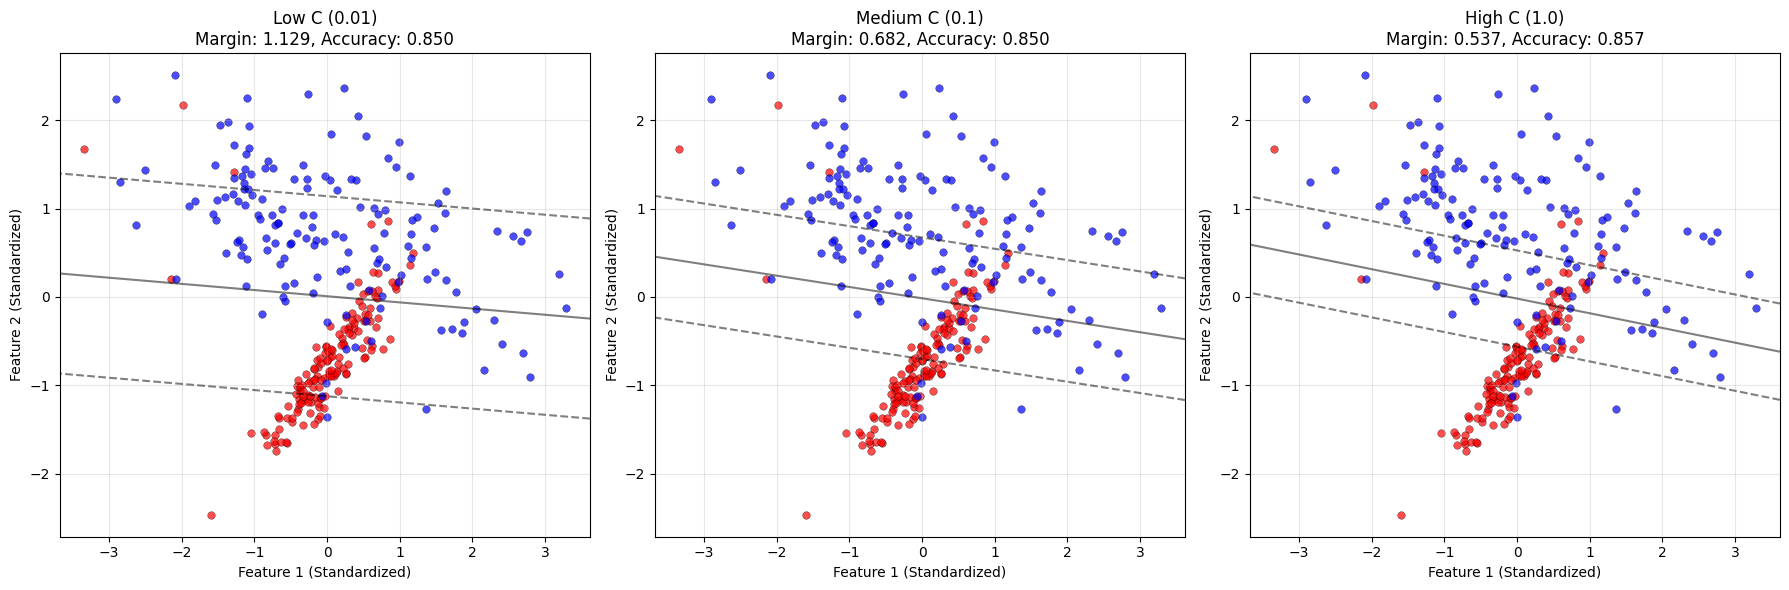

C Parameter Comparison:
C Value    Accuracy   Margin    
----------------------------------------
0.01       0.850      1.129     
0.1        0.850      0.682     
1.0        0.857      0.537     

Key Observations:
• Low C: Larger margin, may sacrifice some accuracy
• High C: Smaller margin, tries to classify everything correctly
• The trade-off between margin maximization and error minimization is clearly visible!


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

def plot_svc_decision_function(model, ax=None, plot_support=False):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

# Test different C values
C_values = [0.01, 0.1, 1.0]
C_labels = ['Low C (0.01)', 'Medium C (0.1)', 'High C (1.0)']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

results = []

for i, (C_val, C_label) in enumerate(zip(C_values, C_labels)):
    # Fit SVM with different C values
    svm_model = SVC(kernel='linear', C=C_val, random_state=42)
    svm_model.fit(X_scaled, y)
    
    # Make predictions and calculate metrics
    y_pred = svm_model.predict(X_scaled)
    accuracy = accuracy_score(y, y_pred)
    
    # Calculate margin
    w = svm_model.coef_[0]
    margin = 1 / np.linalg.norm(w)
    
    # Store results
    results.append({
        'C': C_val,
        'accuracy': accuracy,
        'margin': margin,
        'n_support_vectors': len(svm_model.support_)
    })
    
    # Plot on subplot
    ax = axes[i]
    
    # Plot the data points
    colors = ['red', 'blue']
    for class_val in [0, 1]:
        mask = y == class_val
        ax.scatter(X_scaled[mask, 0], X_scaled[mask, 1], c=colors[class_val], 
                   alpha=0.7, s=30, edgecolors='black', linewidth=0.3)
    
    # Plot SVM decision function
    plot_svc_decision_function(svm_model, ax, plot_support=False)
    
    ax.set_xlabel('Feature 1 (Standardized)')
    ax.set_ylabel('Feature 2 (Standardized)')
    ax.set_title(f'{C_label}\nMargin: {margin:.3f}, Accuracy: {accuracy:.3f}')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison table
print("C Parameter Comparison:")
print("=" * 40)
print(f"{'C Value':<10} {'Accuracy':<10} {'Margin':<10}")
print("-" * 40)
for result in results:
    print(f"{result['C']:<10} {result['accuracy']:<10.3f} {result['margin']:<10.3f}")

Kernel trick?

Looking at our results, we can clearly see that margin gets progressively smaller as C increases - this is because higher C values penalize misclassifications more heavily, forcing the decision boundary to fit the training data more tightly at the expense of margin width.

But wait - we're only looking at **training accuracy** here! To truly evaluate which C value works best, we need to see how well each model **generalizes to unseen data**. 

Let's use **cross-validation** to get a more robust evaluation and look at comprehensive **classification metrics** including precision, recall, and F1-score to understand the full performance picture.

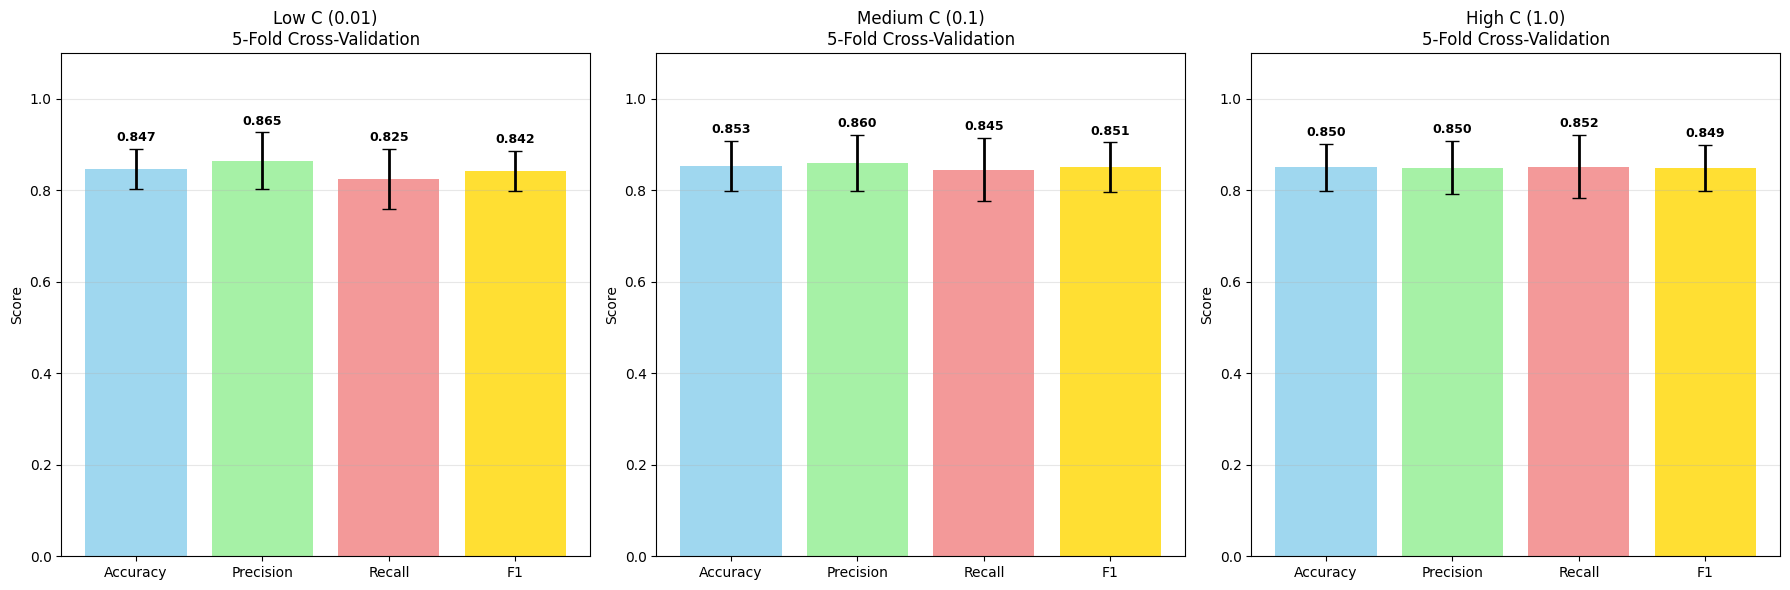

SVM Cross-Validation Results Summary:
C Value    Accuracy     Precision    Recall       F1-Score    
----------------------------------------------------------------------
0.01       0.847±0.044  0.865±0.062  0.825±0.065  0.842±0.044 
0.1        0.853±0.055  0.860±0.062  0.845±0.070  0.851±0.054 
1.0        0.850±0.052  0.850±0.059  0.852±0.070  0.849±0.051 


In [108]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score

# Define scoring metrics for cross-validation
scoring = {
    'accuracy': 'accuracy',
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1': make_scorer(f1_score)
}

# Test different C values
C_values = [0.01, 0.1, 1.0]
C_labels = ['Low C (0.01)', 'Medium C (0.1)', 'High C (1.0)']

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
all_results = []

for i, (C_val, C_label) in enumerate(zip(C_values, C_labels)):
    # Create SVM model with specific C value
    svm_model = SVC(kernel='linear', C=C_val, random_state=42)
    
    # Perform 5-fold cross-validation with multiple metrics
    cv_results = cross_validate(svm_model, X_scaled, y, cv=cv, scoring=scoring)
    
    # Calculate means and standard deviations
    metrics_summary = {}
    for metric in ['accuracy', 'precision', 'recall', 'f1']:
        scores = cv_results[f'test_{metric}']
        metrics_summary[metric] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores
        }
    
    all_results.append(metrics_summary)
    
    # Visualize metrics with error bars
    ax = axes[i]
    metrics_names = [metric.capitalize() for metric in metrics_summary.keys()]
    means = [results['mean'] for results in metrics_summary.values()]
    stds = [results['std'] for results in metrics_summary.values()]

    bars = ax.bar(metrics_names, means, yerr=stds, 
                  color=['skyblue', 'lightgreen', 'lightcoral', 'gold'], 
                  alpha=0.8, capsize=5, error_kw={'elinewidth': 2})

    # Add value labels on bars
    for bar, mean, std in zip(bars, means, stds):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + std + 0.01, 
                f'{mean:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=9)

    ax.set_ylabel('Score')
    ax.set_title(f'{C_label}\n5-Fold Cross-Validation')
    ax.set_ylim(0, 1.1)
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Print comparison table
print("SVM Cross-Validation Results Summary:")
print("=" * 70)
print(f"{'C Value':<10} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12}")
print("-" * 70)

for i, (C_val, results) in enumerate(zip(C_values, all_results)):
    accuracy = f"{results['accuracy']['mean']:.3f}±{results['accuracy']['std']:.3f}"
    precision = f"{results['precision']['mean']:.3f}±{results['precision']['std']:.3f}"
    recall = f"{results['recall']['mean']:.3f}±{results['recall']['std']:.3f}"
    f1 = f"{results['f1']['mean']:.3f}±{results['f1']['std']:.3f}"
    
    print(f"{C_val:<10} {accuracy:<12} {precision:<12} {recall:<12} {f1:<12}")

Looking at our cross-validation results, we can see that **there isn't a dramatic difference between the different C values** - all three perform quite similarly with scores around 0.84-0.86 across all metrics.

The similar performance across different C values suggests our dataset is well-behaved and not extremely sensitive to the regularization parameter; next, we'll examine ROC curves and confusion matrices to better understand the types of classification errors each model makes.

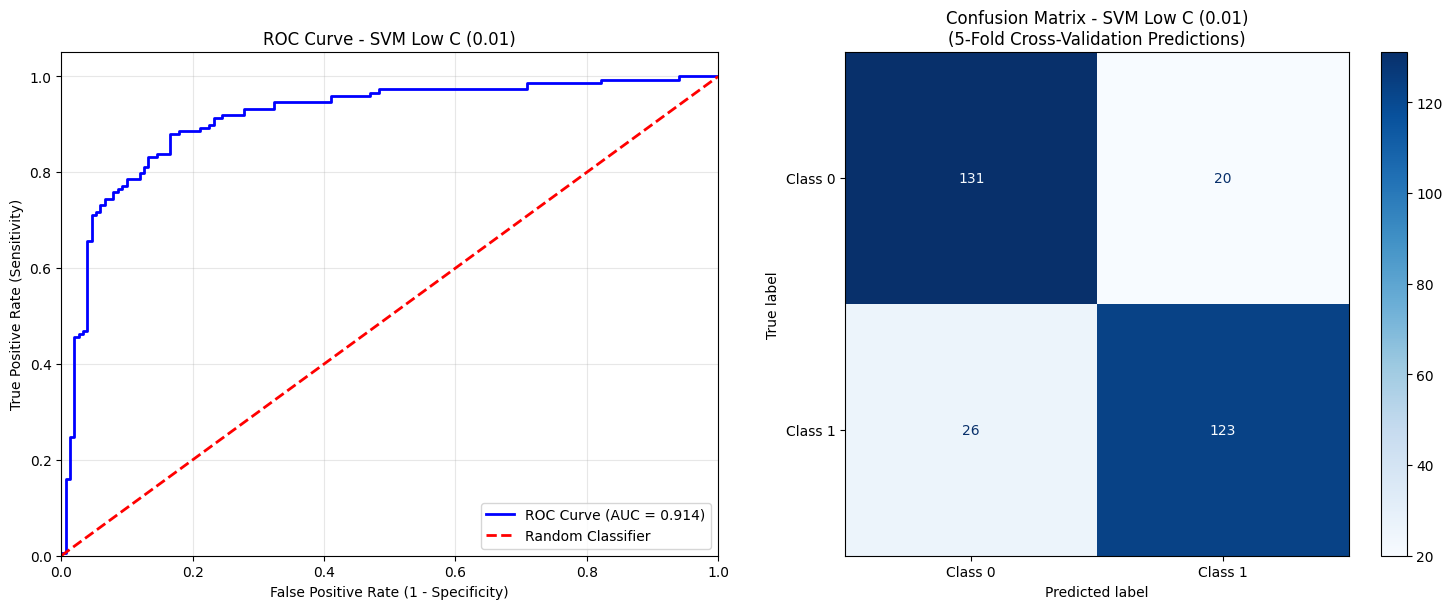

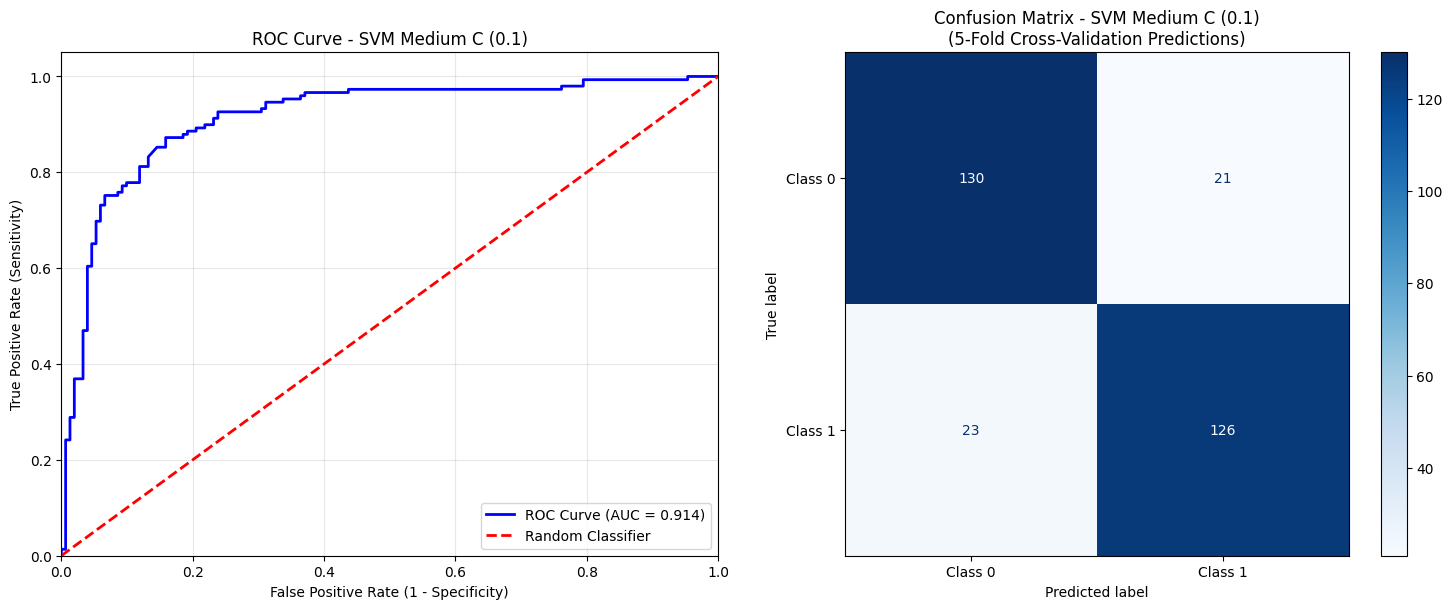

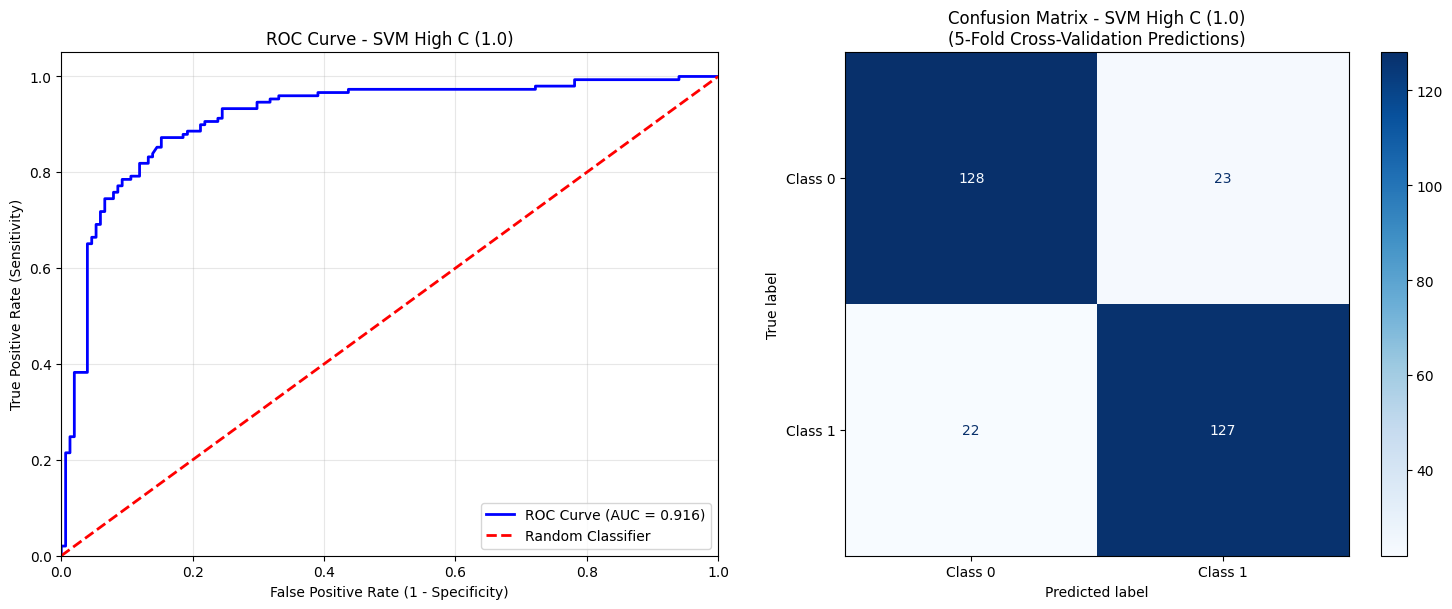

In [111]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict

def plot_roc_and_confusion_matrix(model, X, y, cv, model_name):
    """
    Plot ROC curve and confusion matrix for a given model using cross-validation
    """
    # Get probability predictions and regular predictions using cross-validation
    y_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')
    y_pred = cross_val_predict(model, X, y, cv=cv)

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)

    # Calculate confusion matrix
    cm = confusion_matrix(y, y_pred)

    # Get AUC scores from cross-validation
    auc_scores = cross_validate(model, X, y, cv=cv, scoring='roc_auc')['test_score']

    #print(f"{model_name.upper()} PERFORMANCE SUMMARY")
    #print("=" * 50)
    #print(f"Cross-validation AUC: {auc_scores.mean():.3f} (±{auc_scores.std():.3f})")
    #print("\nConfusion Matrix:")
    #print(f"True Negatives (TN):  {cm[0,0]}")
    #print(f"False Positives (FP): {cm[0,1]}")
    #print(f"False Negatives (FN): {cm[1,0]}")
    #print(f"True Positives (TP):  {cm[1,1]}")

    # Calculate error rates
    total = cm.sum()
    error_rate = (cm[0,1] + cm[1,0]) / total
    #print(f"\nOverall Error Rate: {error_rate:.1%}")
    #print(f"Type I Error (False Positive Rate): {cm[0,1]/cm[0].sum():.1%}")
    #print(f"Type II Error (False Negative Rate): {cm[1,0]/cm[1].sum():.1%}")

    # Create side-by-side plots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # ROC Curve
    ax1 = axes[0]
    ax1.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    ax1.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Classifier')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('False Positive Rate (1 - Specificity)')
    ax1.set_ylabel('True Positive Rate (Sensitivity)')
    ax1.set_title(f'ROC Curve - {model_name}')
    ax1.legend(loc="lower right")
    ax1.grid(True, alpha=0.3)

    # Confusion Matrix
    ax2 = axes[1]
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Class 0', 'Class 1'])
    disp.plot(ax=ax2, cmap='Blues', values_format='d')
    ax2.set_title(f'Confusion Matrix - {model_name}\n(5-Fold Cross-Validation Predictions)')

    plt.tight_layout()
    plt.show()
    
    return roc_auc, cm

# Test different C values
C_values = [0.01, 0.1, 1.0]
C_labels = ['SVM Low C (0.01)', 'SVM Medium C (0.1)', 'SVM High C (1.0)']

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Plot for each C value
for C_val, C_label in zip(C_values, C_labels):
    svm_model = SVC(kernel='linear', C=C_val, random_state=42, probability=True)
    roc_auc, cm = plot_roc_and_confusion_matrix(svm_model, X_scaled, y, cv, C_label)

All three C values show **very strong performance**:

- **ROC Curves**: All achieve AUC scores around 0.92, indicating excellent discrimination ability
- **Confusion Matrices**: Very few misclassifications

The ROC curves are all well above the diagonal (random classifier line), and the confusion matrices show predominantly correct classifications along the diagonal.

Let's wrap it up with an overview of the different methods!

---
<br><br>
# **Classification Methods Comparison**

| **Aspect** | **Logistic Regression** | **K-Nearest Neighbors (KNN)** | **Support Vector Machine (SVM)** |
|------------|-------------------------|--------------------------------|-----------------------------------|
| **Ease of Use** | Simple, works out-of-the-box | Very intuitive concept | Moderate complexity |
| **Training Speed** | Very fast | No training (lazy learning) | Fast for linear kernels |
| **Prediction Speed** | Very fast | Slow (searches all neighbors) | Fast |
| **Accuracy** | Good baseline performance | Good for local patterns | Excellent with proper tuning |
| **Overfitting Risk** | Low with regularization | High with small k | Controlled by C parameter |
| **Complex Patterns** | Linear relationships only | Captures local non-linearity | Excellent with kernel trick (not yet introduced) |
| **Robustness** | Sensitive to outliers | Very sensitive to outliers | Robust (focuses on support vectors) |
| **Memory Usage** | Low (stores coefficients) | High (stores all training data) | Moderate (stores support vectors) |

## **Interpretability**

| **Method** | **What You Can Understand** |
|------------|------------------------------|
| **Logistic Regression** | Exact feature importance via coefficients; odds ratios; statistical significance |
| **KNN** | Can examine actual neighbor cases; understand local decision patterns |
| **SVM** | Support vectors show critical cases; coefficients less interpretable than logistic regression |

### **Clinical Decision Guide**
- **Logistic Regression**: Interpretability crucial, statistical inference needed, linear relationships
- **KNN**: Local patterns important, case-based reasoning, irregular decision boundaries
- **SVM**: Maximum accuracy priority, complex data, robust classification needed
- **Best Practice**: Start with Logistic Regression → try KNN for local patterns → use SVM for maximum performance

---
<br><br>
# Transition to Medical Dataset

Now let's apply the newly learned tools to a real world medical dataset.